In [147]:
import pandas as pd
import openpyxl
import h5py
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
import sys
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Experiment Hyperparameters

In [148]:
is_local = True # todo

# Experiment
seed = 0 if is_local else int(sys.argv[-2])
torch.manual_seed(seed)
image_size = 256

# Data: which wavenumbers are even allowed to be considered?
wv_start = 0
wv_end = 965

# Data loading
test_set_fraction = 0.2
val_set_fraction = 0.2
batch_size= 64 # todo
patch_dim = 25
use_augmentation = True
embed_dim=256

# Network
dropout_p=0.5

# Training schedule
lr = 5e-4
l2 = 5e-2 # 5e-1
max_iters = 5000
pseudo_epoch = 100

# dimensionality reduction parameters
r_method = 'linear' # {'linear','pca,'fixed'}
reduce_dim = 64 if is_local else int(sys.argv[-1]) # used only for r_method = 'pca' or 'linear'
channels_used = np.s_[...,wv_start:wv_end] # used only when r_method = 'fixed'
print(channels_used)

(Ellipsis, slice(0, 965, None))


In [149]:
def csf_fp(filepath):
    return filepath.replace('D:/datasets','D:/datasets' if is_local else './')

master = pd.read_excel(csf_fp(rf'D:/datasets/pcuk2023_ftir_whole_core/master_sheet.xlsx'))
slide = master['slide'].to_numpy()
patient_id = master['patient_id'].to_numpy()
hdf5_filepaths = np.array([csf_fp(fp) for fp in master['hdf5_filepath']])
annotation_filepaths = np.array([csf_fp(fp) for fp in master['annotation_filepath']])
mask_filepaths = np.array([csf_fp(fp) for fp in master['mask_filepath']])
wavenumbers = np.load(csf_fp(f'D:/datasets/pcuk2023_ftir_whole_core/wavenumbers.npy'))[wv_start:wv_end]
wavenumbers_used = wavenumbers[channels_used]

seq_len = len(wavenumbers_used) if r_method == 'fixed' else reduce_dim 

annotation_class_colors = np.array([[0,255,0],[128,0,128],[255,0,255],[0,0,255],[255,165,0],[255,0,0]])
annotation_class_names = np.array(['epithelium_n','stroma_n','epithelium_c','stroma_c','corpora_amylacea','blood'])
n_classes = len(annotation_class_names)
print(f"Loaded {len(slide)} cores")
print(f"Using {len(wavenumbers_used)}/{len(wavenumbers)} wavenumbers")

Loaded 228 cores
Using 965/965 wavenumbers


## Define Datasets, Dataloaders

In [150]:
unique_pids = np.unique(patient_id)
pids_trainval, pids_test, _, _ = train_test_split(
    unique_pids, np.zeros_like(unique_pids), test_size=test_set_fraction, random_state=seed)
pids_train, pids_val, _, _ = train_test_split(
    pids_trainval, np.zeros_like(pids_trainval), test_size=(val_set_fraction/(1-test_set_fraction)), random_state=seed)
where_train = np.where(np.isin(patient_id,pids_train))
where_val = np.where(np.isin(patient_id,pids_val))
where_test = np.where(np.isin(patient_id,pids_test))
print(f"Patients per data split:\n\tTRAIN: {len(where_train[0])}\n\tVAL: {len(where_val[0])}\n\tTEST: {len(where_test[0])}")

Patients per data split:
	TRAIN: 135
	VAL: 49
	TEST: 44


In [151]:
class ftir_patching_dataset(torch.utils.data.Dataset):
    def __init__(self,hdf5_filepaths, mask_filepaths, annotation_filepaths, channels_use,
                 patch_dim=25, augment=True,):
        
        # Define data paths
        self.hdf5_filepaths = hdf5_filepaths
        self.mask_filepaths = mask_filepaths
        self.annotation_filepaths = annotation_filepaths
        self.augment = augment
        
        # patch dimensions
        self.patch_dim = patch_dim
        self.patch_minus = patch_dim //2; self.patch_plus = 1 + (patch_dim // 2)
        self.channels = channels_use
        
        # class data
        self.annotation_class_colors = annotation_class_colors
        self.annotation_class_names = annotation_class_names
        self.total_sampled = torch.zeros(len(self.annotation_class_colors))
        
        # define data augmentation pipeline
        self.transforms = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
        ])
        
        # Open every core hdf5 file
        self.open()
        
    def __len__(self):
        return self.total_pixels
    
    def __getitem__(self,idx):
        # get patch data
        row = self.rows[idx]
        col = self.cols[idx]
        cidx = self.cidxs[idx]
        label = self.tissue_classes[idx]
        self.total_sampled[label] += 1
        
        # Are dimensions of patch okay
        idx_u = row - self.patch_minus
        idx_d = row + self.patch_plus
        idx_l = col - self.patch_minus
        idx_r = col + self.patch_plus
        pad_u = max(-idx_u,0); idx_u = max(idx_u,0)
        pad_d = max(idx_d-image_size,0); idx_d = min(idx_d,image_size)
        pad_l = max(-idx_l,0); idx_l = max(idx_l,0)
        pad_r = max(idx_r-image_size,0); idx_r = min(idx_r,image_size)
        
        # get patch
        patch = torch.from_numpy(
            self.hdf5_files[cidx]['spectra'][idx_u:idx_d,idx_l:idx_r,*self.channels],
        ).permute(2,0,1)
        patch *= torch.from_numpy(
            self.hdf5_files[cidx]['mask'][idx_u:idx_d,idx_l:idx_r,],
        ).unsqueeze(0)
        
        # pad patch
        patch = torch.nn.functional.pad(patch,(pad_l,pad_r,pad_u,pad_d,0,0))
        
        if self.augment:
            patch = self.transforms(patch)
        return patch,label

    # split annotations from H x W x 3 to C x H x W, one/zerohot along C dimension
    def split_annotations(self,annotations_img):
        split = torch.zeros((len(self.annotation_class_colors),*annotations_img.shape[:-1]))
        for c,col in enumerate(annotation_class_colors):
            split[c,:,:] = torch.from_numpy(np.all(annotations_img == self.annotation_class_colors[c],axis=-1)) 
        return split
    
    # open every file 
    def open(self):
        self.hdf5_files = []
        self.tissue_classes = []
        self.rows = []
        self.cols = []
        self.cidxs = []
        
        # for every core in dataset,
        for cidx in range(0,len(self.hdf5_filepaths)):
            # open annotations and remove edges and non-tissue px
            annotation = self.split_annotations(cv2.imread(self.annotation_filepaths[cidx])[:,:,::-1])
            mask = torch.from_numpy(cv2.imread(self.mask_filepaths[cidx])[:,:,1]) / 255
            annotation *= mask
            # for every class,
            for cls in range(len(annotation_class_names)):
                # get location of annotations, append to lists
                r,c = torch.where(annotation[cls])
                num_cls = annotation[cls].sum().int().item()
                self.tissue_classes.extend([cls,]*num_cls)
                self.cidxs.extend([cidx,]*num_cls)
                self.rows.extend(r)
                self.cols.extend(c)
            # add open hdf5 file to list
            self.hdf5_files.append(h5py.File(self.hdf5_filepaths[cidx],'r'))
                
        # construct data tensors
        self.rows = torch.Tensor(self.rows).int()
        self.cols = torch.Tensor(self.cols).int()
        self.tissue_classes = torch.Tensor(self.tissue_classes).long()
        self.cidxs = torch.Tensor(self.cidxs).int()
        self.total_pixels = len(self.cidxs)

    # close every open hdf5 file
    def close(self):
        for cidx in range(len(self.hdf5_files)):
            self.hdf5_files[cidx].close()
        self.hdf5_files = []
        self.tissue_classes = []
        self.xs = []
        self.ys = []

In [152]:
dataset_train = ftir_patching_dataset(
    hdf5_filepaths[where_train], mask_filepaths[where_train], annotation_filepaths[where_train], channels_used,
    patch_dim = patch_dim, augment=use_augmentation,
)
dataset_val = ftir_patching_dataset(
    hdf5_filepaths[where_val], mask_filepaths[where_val], annotation_filepaths[where_val], channels_used,
    patch_dim = patch_dim, augment=False,
)
dataset_test = ftir_patching_dataset(
    hdf5_filepaths[where_test], mask_filepaths[where_test], annotation_filepaths[where_test], channels_used,
    patch_dim = patch_dim, augment=False,
)

# Instiantiate data loaders
_, class_counts = np.unique(dataset_train.tissue_classes, return_counts=True)
class_weights = 1 / class_counts
class_weights = class_weights[dataset_train.tissue_classes]
train_sampler = torch.utils.data.WeightedRandomSampler(class_weights, len(class_weights), replacement=True)

_, class_counts = np.unique(dataset_val.tissue_classes, return_counts=True)
class_weights = 1 / class_counts
class_weights = class_weights[dataset_val.tissue_classes]
val_sampler = torch.utils.data.WeightedRandomSampler(class_weights, len(class_weights), replacement=True)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler,drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, sampler=val_sampler,drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,shuffle=True,drop_last=True)
print(f"loader sizes:\n\ttrain: {len(train_loader)}\n\tval: {len(val_loader)}\n\ttest: {len(test_loader)}")

loader sizes:
	train: 5992
	val: 2013
	test: 1793


## Define dimensionality reduction method

In [153]:
class LinearReduction(nn.Module):
    def __init__(self,input_dim,reduce_dim):
        super().__init__()
        self.reduce_dim = reduce_dim
        self.input_norm = nn.BatchNorm2d(input_dim)
        self.projection = nn.Conv2d(input_dim,reduce_dim,kernel_size=1,stride=1) # todo bias = false?
        self.projection_norm = nn.BatchNorm2d(reduce_dim)
    
    def forward(self,x):
        return self.projection_norm(self.projection(self.input_norm(x)))
    
class PCAReduce(nn.Module): # todo need to add batchnorm here too?
    def __init__(self,reduce_dim,means,loadings):
        super().__init__()
        self.reduce_dim = reduce_dim
        self.register_buffer('means', torch.from_numpy(means).float().reshape(1,-1,1,1))
        self.register_buffer('loadings', torch.from_numpy(loadings).float())
    
    def forward(self,x):
        projected = x - self.means
        
        b,c,h,w = projected.shape
        projected = projected.permute(0,2,3,1).reshape(b,h*w,c)
        projected = torch.matmul(projected, self.loadings.T)
        projected = projected.reshape(b,h,w,self.reduce_dim).permute(0,3,1,2)
        
        return projected
        
class FixedReduction(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.input_norm = nn.BatchNorm2d(input_dim)
    
    def forward(self,x):
        return self.input_norm(x)

if r_method == 'pca':
    spectral_sample = []
    batch_samples = 0
    for data,label in train_loader:
        spectral_sample.append(data[...,patch_dim//2,patch_dim//2].numpy())
        batch_samples += 1
        if batch_samples > 10000//batch_size: break
    spectral_sample = np.concatenate(spectral_sample,axis=0)
    spectral_means = np.mean(spectral_sample,axis=0)
    spectral_sample -= spectral_means
    pca = PCA(n_components=reduce_dim)
    pca.fit(spectral_sample)
    spectral_loadings = pca.components_

## Define Model

In [154]:
class LearnablePositionEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0, sequence_length: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.pe = nn.Parameter(torch.tensor(np.random.normal(loc=0.0, scale=0.02, size=(1, sequence_length, d_model)),dtype=torch.float32))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe
        return self.dropout(x)

class patch25_transformer(nn.Module):
    def __init__(self,input_dim,reduce_dim,n_classes,embed_dim):
        super().__init__()
        # input processing and dimensionality reduction
        if r_method == 'pca':
            self.input_processing = PCAReduce(reduce_dim,spectral_means,spectral_loadings)
        elif r_method == 'fixed':
            self.input_processing = FixedReduction(input_dim)
        elif r_method == 'linear':
            self.input_processing = LinearReduction(input_dim,reduce_dim)
            
        self.d_model = embed_dim
        self.cls_token = nn.Parameter(torch.normal(torch.zeros((1,1,self.d_model)),0.02))
            
        self.patch_project = nn.Conv3d(
                1,
                embed_dim,
                kernel_size=(1,patch_dim,patch_dim),
        )
            
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=16,
            dim_feedforward=256,
            activation="gelu",
            batch_first=True)
        self.encoder_stack = nn.TransformerEncoder(
            encoder_layer=self.encoder_layer,
            num_layers=6)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.d_model,n_classes),
        )
        
        self.pe = LearnablePositionEncoding(
            d_model=self.d_model,
            dropout=0,
            sequence_length=seq_len + 1
        )
        
    def forward(self, x):
        x = self.input_processing(x)
        x = self.patch_project(x.unsqueeze(1)) # X -> B x 1 x C x H x W -> B x K x C x 1 x 1 -> 
        x = x.squeeze().permute(0,2,1) # X -> B x C x K
        x = torch.cat([self.cls_token.expand(x.shape[0],-1,-1),x],dim=1)
        x_pe = self.pe(x)
        x_tr = self.encoder_stack(x_pe)
        logits = self.classifier(x_tr[:, 0])
        return logits


In [155]:
model = patch25_transformer(
    input_dim=len(wavenumbers_used),
    reduce_dim=len(wavenumbers_used) if r_method == 'fixed' else reduce_dim,
    n_classes=n_classes,
    embed_dim=embed_dim,
)

print(f"fusion_model with {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.3f}M params composed of:")
model = model.to(device)

fusion_model with 3.013M params composed of:


## Training Loop

In [159]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=l2)
linear_warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=100)
cosine_lr = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 100, T_mult=2, eta_min=0.0, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer,
    [
        linear_warmup,
        cosine_lr,
    ], 
    milestones=[100,], 
    last_epoch=max_iters)

In [160]:
training_losses,validation_losses = [],[]
training_accs,validation_accs = [],[]
training_f1ms,validation_f1ms = [],[]
training_f1s,validation_f1s = [],[]
learning_rate_log = []
current_iters = 0
best_val_f1 = 0
best_val_iter = 0
patience = 500
tolerance = 0.01
stop_training=False

In [161]:
while current_iters < max_iters:
    for (bidx, (data, label)) in enumerate(train_loader):
        data = data.to(device); label = label.to(device)
        
        # Push through model
        model.train()
        optimizer.zero_grad()
        out = model(data)
        
        # Calculate loss
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()
        
        # Append log arrays
        training_losses.append(loss.item())
        pred = out.argmax(dim=1).detach().cpu().numpy()
        actual = label.cpu().numpy()
        training_accs.append(accuracy_score(actual,pred))
        training_f1ms.append(f1_score(actual, pred, average='macro'))
        training_f1s.append(f1_score(actual, pred, average=None, labels=np.arange(0,n_classes),zero_division=0))
        
        # Do validation cycle
        model.eval()
        with torch.no_grad():
            # load data
            data, label = next(iter(val_loader))
            data = data.to(device); label = label.to(device)
            
            # Push through model
            out = model(data)
            
            # Calculate loss
            loss = loss_fn(out, label)
            
            # Append log arrays
            validation_losses.append(loss.item())
            pred = out.argmax(dim=1).detach().cpu().numpy()
            actual = label.cpu().numpy()
            validation_accs.append(accuracy_score(actual,pred))
            validation_f1ms.append(f1_score(actual, pred, average='macro'))
            validation_f1s.append(f1_score(actual, pred, average=None, labels=np.arange(0,n_classes),zero_division=0))
        
        # Print training statistics every N iters
        if current_iters % pseudo_epoch == 0:
            print(f"ON ITER: {current_iters}, metrics for last {pseudo_epoch} iters:")
            print(f"TRAIN --- | Loss: {np.mean(training_losses[-pseudo_epoch:]):.4} | OA: {np.mean(training_accs[-pseudo_epoch:]):.4} | F1M: {np.mean(training_f1ms[-pseudo_epoch:]):.4f}")
            print(f"VAL ----- | Loss: {np.mean(validation_losses[-pseudo_epoch:]):.4} | OA: {np.mean(validation_accs[-pseudo_epoch:]):.4} | F1M: {np.mean(validation_f1ms[-pseudo_epoch:]):.4f}")
        
        # If performance on validation set best so far, save model
        if np.mean(validation_f1ms[-pseudo_epoch:]) > best_val_f1:
            best_val_f1 = np.mean(validation_f1ms[-pseudo_epoch:])
            best_val_iter = current_iters
            if not is_local:
                torch.save(model.state_dict(), rf'./model_weights_{seed}.pt')
        
        scheduler.step()
        learning_rate_log.extend(scheduler.get_last_lr())
        
        # Step the scheduler based on the validation set performance
        current_iters += 1
        if current_iters > max_iters: 
            stop_training = True
            break
        
        # early stopping criterion    
        # todo
    if stop_training: break

training_losses = np.array(training_losses); validation_losses = np.array(validation_losses)
training_accs = np.array(training_accs); validation_accs = np.array(validation_accs)
training_f1ms = np.array(training_f1ms); validation_f1ms = np.array(validation_f1ms)
training_f1s = np.stack(training_f1s,axis=0); validation_f1s = np.stack(validation_f1s,axis=0)
print(f"Training complete after {current_iters} iterations\n\ttotal samples       :    {current_iters*batch_size}\n\t -=-=-=-=-=-=-=-=-=-=-=-=-=-")
for cls_idx, samples_loaded in enumerate(dataset_train.total_sampled.numpy()):
    print(f"\t{annotation_class_names[cls_idx]}{(20-len(annotation_class_names[cls_idx])) * ' '}:    {int(samples_loaded)}")
print(f"Metrics for final {pseudo_epoch} iterations:")
print(f"TRAIN --- | Loss: {training_losses[-pseudo_epoch:].mean():.4f} | OA: {training_accs[-pseudo_epoch:].mean():.4f} | f1: {training_f1ms[-pseudo_epoch:].mean():.4f}")
print(f"VAL ----- | Loss: {validation_losses[-pseudo_epoch:].mean():.4f} | OA: {validation_accs[-pseudo_epoch:].mean():.4f} | f1: {validation_f1ms[-pseudo_epoch:].mean():.4f}")

ON ITER: 0, metrics for last 100 iters:
TRAIN --- | Loss: 1.395 | OA: 0.4688 | F1M: 0.3594
VAL ----- | Loss: 2.428 | OA: 0.125 | F1M: 0.0370
ON ITER: 100, metrics for last 100 iters:
TRAIN --- | Loss: 0.7849 | OA: 0.6594 | F1M: 0.6332
VAL ----- | Loss: 2.452 | OA: 0.2772 | F1M: 0.1854
ON ITER: 200, metrics for last 100 iters:
TRAIN --- | Loss: 0.4794 | OA: 0.7925 | F1M: 0.7774
VAL ----- | Loss: 0.6176 | OA: 0.7606 | F1M: 0.7421
ON ITER: 300, metrics for last 100 iters:
TRAIN --- | Loss: 0.321 | OA: 0.8698 | F1M: 0.8626
VAL ----- | Loss: 0.5366 | OA: 0.8064 | F1M: 0.7923
ON ITER: 400, metrics for last 100 iters:
TRAIN --- | Loss: 0.3608 | OA: 0.8611 | F1M: 0.8550
VAL ----- | Loss: 0.6431 | OA: 0.783 | F1M: 0.7709
ON ITER: 500, metrics for last 100 iters:
TRAIN --- | Loss: 0.2791 | OA: 0.8975 | F1M: 0.8913
VAL ----- | Loss: 0.6241 | OA: 0.7825 | F1M: 0.7721
ON ITER: 600, metrics for last 100 iters:
TRAIN --- | Loss: 0.1928 | OA: 0.9291 | F1M: 0.9254
VAL ----- | Loss: 0.5671 | OA: 0.82 | 


KeyboardInterrupt



## Test Loop

In [ ]:
running_loss_test = 0
test_preds, test_targets = [], []

if not is_local:
    model.load_state_dict(torch.load(rf'./model_weights_{seed}.pt', weights_only=True))

model.eval()
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_loader):
        print(f"Iter: {batch_idx}/{len(test_loader)}",end="\r")        
        data = data.to(device)
        label = label.to(device)

        # Push through model
        out = model(data)
        loss = loss_fn(out, label)

        # Calculate metrics
        running_loss_test += loss.cpu().item() 
        pred = out.argmax(dim=1).detach().cpu().numpy()
        actual = label.cpu().numpy()
        test_preds.extend(pred)
        test_targets.extend(actual)

test_targets = np.array(test_targets); test_preds = np.array(test_preds)
test_loss = running_loss_test / batch_idx
test_acc = accuracy_score(test_targets, test_preds)
test_f1m = f1_score(test_targets, test_preds, average='macro')
test_f1 = f1_score(test_targets, test_preds, average=None)

print("Metrics on entire testing set:")
print(f"TEST ---- | Loss: {test_loss:.4f} | OA: {test_acc:.4f} | f1: {test_f1m:.4f}")
for cls_idx, f1 in enumerate(test_f1):
    print(f"{annotation_class_names[cls_idx]}{(20 - len(annotation_class_names[cls_idx])) * ' '} : {f1:.4f}")
print("Total samples loaded for each class during TESTING")
for cls_idx, samples_loaded in enumerate(dataset_test.total_sampled.numpy()):
    print(f"{annotation_class_names[cls_idx]}{(20-len(annotation_class_names[cls_idx])) * ' '}:    {int(samples_loaded)}")

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))
locarray = np.zeros((seq_len,seq_len))
cos = nn.CosineSimilarity(dim=0)
for r in range(seq_len):
    for c in range(seq_len):
        locarray[r,c] = cos(model.pe.pe[0][r + 1],model.pe.pe[0][c + 1]).detach().cpu().numpy()
fig.suptitle("Cosine similarity of position embeddings")
ax.matshow(locarray)
fig.tight_layout()
if not is_local:
    plt.savefig(f'./position_embedding_{seed}.png'); plt.close(fig)

## Evaluation

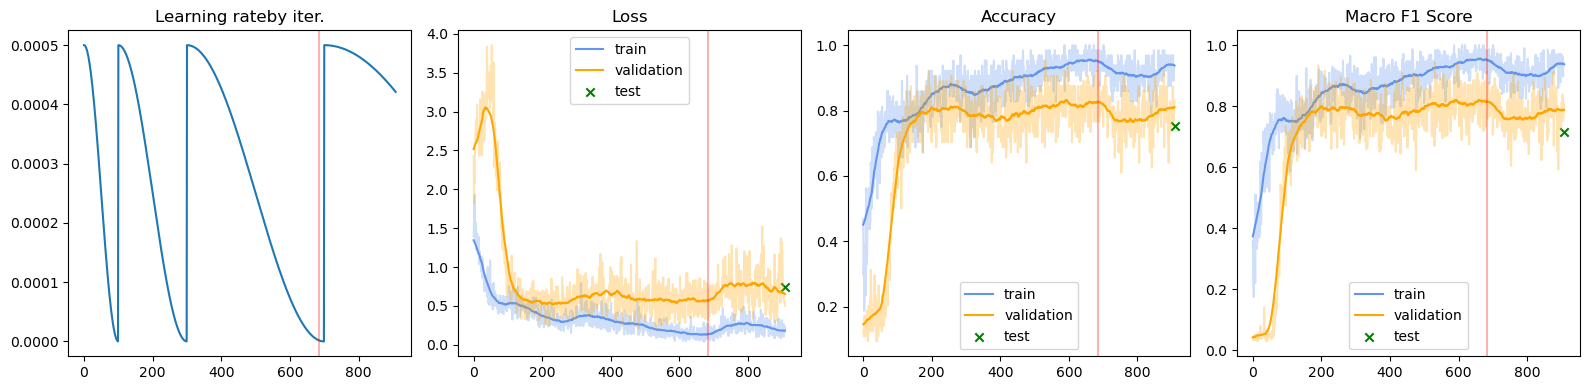

In [162]:
def moving_average(a, n=3): # https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
    a = np.pad(a, ((n-1)//2,(n-1)//2 + ((n-1) % 2)), mode='edge')
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

fig,ax = plt.subplots(1,4,figsize=(16,4))
ax[0].plot(np.arange(0,len(learning_rate_log)),learning_rate_log)
ax[0].set_title("Learning rateby iter.")

ax[1].plot(np.arange(0,len(moving_average(training_losses,n=1))),moving_average(training_losses,n=1),alpha=0.3,color='cornflowerblue')
ax[1].plot(np.arange(0,len(moving_average(training_losses,n=50))),moving_average(training_losses,n=50),alpha=1,color='cornflowerblue',label="train")
ax[1].plot(np.arange(0,len(moving_average(validation_losses,n=1))),moving_average(validation_losses,n=1),alpha=0.3,color='orange')
ax[1].plot(np.arange(0,len(moving_average(validation_losses,n=50))),moving_average(validation_losses,n=50),alpha=1,color='orange',label="validation")
ax[1].scatter(current_iters,test_loss,color='green',label="test",marker="x")
ax[1].set_title("Loss"); ax[1].legend()

ax[2].plot(np.arange(0,len(moving_average(training_accs,n=1))),moving_average(training_accs,n=1),alpha=0.3,color='cornflowerblue')
ax[2].plot(np.arange(0,len(moving_average(training_accs,n=50))),moving_average(training_accs,n=50),alpha=1,color='cornflowerblue',label="train")
ax[2].plot(np.arange(0,len(moving_average(validation_accs,n=1))),moving_average(validation_accs,n=1),alpha=0.3,color='orange')
ax[2].plot(np.arange(0,len(moving_average(validation_accs,n=50))),moving_average(validation_accs,n=50),alpha=1,color='orange',label="validation")
ax[2].scatter(current_iters,test_acc,color='green',label="test",marker="x")
ax[2].set_title("Accuracy"); ax[2].legend()

ax[3].plot(np.arange(0,len(moving_average(training_f1ms,n=1))),moving_average(training_f1ms,n=1),alpha=0.3,color='cornflowerblue')
ax[3].plot(np.arange(0,len(moving_average(training_f1ms,n=50))),moving_average(training_f1ms,n=50),alpha=1,color='cornflowerblue',label="train")
ax[3].plot(np.arange(0,len(moving_average(validation_f1ms,n=1))),moving_average(validation_f1ms,n=1),alpha=0.3,color='orange')
ax[3].plot(np.arange(0,len(moving_average(validation_f1ms,n=50))),moving_average(validation_f1ms,n=50),alpha=1,color='orange',label="validation")
ax[3].scatter(current_iters,test_f1m,color='green',label="test",marker="x")
ax[3].set_title("Macro F1 Score"); ax[3].legend()

ax[0].axvline(x=best_val_iter, ymin=0, ymax=1, color='red',alpha=0.3)
ax[1].axvline(x=best_val_iter, ymin=0, ymax=1, color='red',alpha=0.3)
ax[2].axvline(x=best_val_iter, ymin=0, ymax=1, color='red',alpha=0.3)
ax[3].axvline(x=best_val_iter, ymin=0, ymax=1, color='red',alpha=0.3)

plt.tight_layout()
if not is_local:
    plt.savefig(f'./loss_curve_{seed}.png'); plt.close(fig)

In [ ]:
training_f1s = np.stack(training_f1s,axis=0)
validation_f1s = np.stack(validation_f1s,axis=0)
fig,ax = plt.subplots(2,3,figsize=(15,5)); ax = ax.flatten()
for cls in range(n_classes):
    ax[cls].plot(np.arange(0,len(moving_average(training_f1s[:,cls],n=1))),moving_average(training_f1s[:,cls],n=1),alpha=0.3,color='k')
    ax[cls].plot(np.arange(0,len(moving_average(training_f1s[:,cls],n=50))),moving_average(training_f1s[:,cls],n=50),alpha=1,color='k',label="train")
    ax[cls].plot(np.arange(0,len(moving_average(validation_f1s[:,cls],n=1))),moving_average(validation_f1s[:,cls],n=1),alpha=0.3,color=annotation_class_colors[cls]/255)
    ax[cls].plot(np.arange(0,len(moving_average(validation_f1s[:,cls],n=50))),moving_average(validation_f1s[:,cls],n=50),alpha=1,color=annotation_class_colors[cls]/255, label="validation")
    ax[cls].scatter(current_iters,test_f1[cls],color=annotation_class_colors[cls]/255,label="test",marker="x")
    ax[cls].set_ylim(ymin=0,ymax=1)
    ax[cls].axvline(x=best_val_iter, ymin=0, ymax=1, color='red',alpha=0.3)
fig.suptitle("Class-specific F1 scores")
plt.tight_layout()
if not is_local:
    plt.savefig(f'./loss_curve_individual_{seed}.png'); plt.close(fig)

## Finish experiment

In [ ]:
if not is_local:
    model = model.cpu()
    torch.save(model.state_dict(), rf'./model_weights_{seed}.pt')

In [ ]:
# Read existing results file
if not is_local:
    if os.path.isfile('results.txt'):
        f = open('results.txt','r')
        lines = f.readlines()
        f.close()
    else: 
        lines = [x+', \n' for x in['seed',*annotation_class_names,'overall_acc','macro_f1']]
        
    # Process files
    lines[0] = lines[0].replace('\n',str(seed) + ', \n')
    for cls in range(n_classes):
        lines[cls+1] = lines[cls+1].replace('\n',str(test_f1[cls]) + ', \n' )
    lines[n_classes+1] = lines[n_classes+1].replace('\n',str(test_acc) + ', \n')
    lines[n_classes+2] = lines[n_classes+2].replace('\n',str(test_f1m) + ', \n')
    
    f = open('results.txt','w')
    f.write(''.join(lines))
    f.close()

In [ ]:
dataset_train.close()
dataset_val.close()
dataset_test.close()